In [87]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

%matplotlib inline

# Definindo uma função

Quando estamos programando e precisamos repetir muito um trecho de código, vem a calhar criarmos uma função com este código.

Podemos co

In [88]:
def make_map(ax,llat=-30,ulat=-20,llon=-50,ulon=-39,resolution='l',nmeridians=3,nparallels=2):

    m = Basemap(projection='merc', llcrnrlat=llat, urcrnrlat=ulat, llcrnrlon=llon, urcrnrlon=ulon, resolution=resolution)

    m.ax = ax

    m.drawcoastlines(linewidth=.5)

    return m

In [89]:
# importando arquivo
DATA_DIR = '/home/danilo/mestrado/arian/' # coloca o diretorio aonde voce tem trabalhado e aonde os dados estão
fname = DATA_DIR + 'CARS_2009_WORLD_MONTHLY_01.nc'

ncin = xr.open_dataset(fname,decode_times=False)

In [90]:
# extraindo uma variavel qualquer para trabalhar
lon = ncin.LONGITUDE.values
lon = ((lon - 180)%360) - 180 # convertendo de 0/360 para -180/180 (o CDO faz isso de forma mais fácil hahaha)
lat = ncin.LATITUDE.values
dep = ncin.DEPTH.values
data = ncin.TEMP[0,:,:,:] # tempo 0, todas as profs, lons e lats


Selecionamos o ponto de início do transecto (continente, por exemplo).

Nesse caso, eu olhei a grade do arquivo netcdf e identifiquei as coordenadas que eu gostaria de utilizar, pra fazer um transecto ao largo de Santos. Faz isso você também, você já fez antes.

In [91]:
# latitude e longitude do começo ao final
ilat,flat = 103, 92
ilon,flon = 626, 637

# recortando: aqui tem um pulo do gato
ndata = data[:,flat:ilat,ilon:flon]
nlon1D= lon[ilon:flon]
nlat1D= lat[flat:ilat]

# gridando a matriz de coordenadas
nlon,nlat = np.meshgrid(nlon1D,nlat1D)

# por via das duvidas, criamos um xplot,yplot para tooodo os lon e lat
xplot,yplot = np.meshgrid(lon,lat)

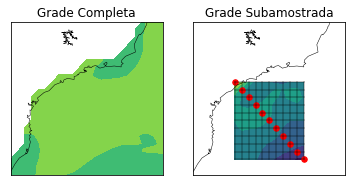

In [92]:
# visualizando o novo campo e aonde sera feito o transecto
fig,axes = plt.subplots(ncols=2)
ax=axes[0]
m = make_map(ax)
m.contourf(xplot,yplot,data[0,:,:],latlon=True)
ax.set_title('Grade Completa')

ax=axes[1]
m = make_map(ax)
m.contourf(nlon,nlat,ndata[0,:,:],latlon=True)
m.plot(nlon,nlat,'k',alpha=.3,latlon=True)
m.plot(nlon.T,nlat.T,'k',alpha=.3,latlon=True)
ax.set_title('Grade Subamostrada')

jindexes = np.arange(10,-1,-1)
iindexes = np.arange(0,11,1)

for j,i in zip(jindexes,iindexes):
    m.scatter(nlon[j,i],nlat[j,i],s=30,c='r',latlon=True)


In [93]:
# criando a martriz do transecto
transect = np.zeros(ndata.shape[0:2])*np.nan

for k in range(ndata.shape[0]):
    for j,i in zip(jindexes,iindexes):
        transect[k,i] = ndata[k,j,i]

Text(0.5,1,'Transecto ao largo de Santos')

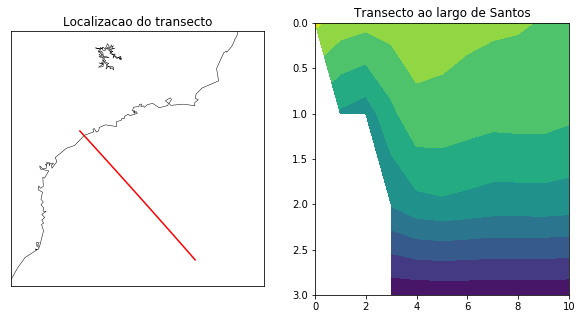

In [94]:
# visualizando a secao vertical
fig,axes = plt.subplots(ncols=2,figsize=(10,5))
ax = axes[0]
m = make_map(ax)
m.plot(nlon[jindexes,iindexes],nlat[jindexes,iindexes],'r',latlon=True)
ax.set_title('Localizacao do transecto')

ax = axes[1]
ax.contourf(transect)
ax.set_ylim([0,3])
ax.invert_yaxis()
ax.set_title('Transecto ao largo de Santos')

Os próximos passos seria plotar o contourf do transecto utilizando a profundidade, no eixo y, e a distância no eixo x. Mas não são coisas triviais de se fazer e, por hora, isso já basta pra você visualizar o comportamento dos nutrientes na coluna d'água.

Tenta fazer isso pra outras duas radiais:

. uma simples: ao largo de Cananéia
. uma complicada: ao largo de Ubatuba

In [95]:
# Calculando o eixo X em forma de distância da """"""linha da costa""""""
jindexes = np.arange(10,-1,-1)
iindexes = np.arange(0,11,1)

distLon = []
distLat = []

for j,i in zip(jindexes,iindexes):
    distLon.append(nlon[j,i])
    distLat.append(nlat[j,i])
    
# distLon é um vetor 1D com as longitudes do transecto
# distLat é um vetor 1D com as latitudes do transecto
print('Longitudes: ' + str(distLon))
print('Latitudes: ' + str(distLat))

Longitudes: [-47.0, -46.5, -46.0, -45.5, -45.0, -44.5, -44.0, -43.5, -43.0, -42.5, -42.0]
Latitudes: [-24.0, -24.5, -25.0, -25.5, -26.0, -26.5, -27.0, -27.5, -28.0, -28.5, -29.0]


Para calcular a distância entre coordenadas, usamos um pacote chamado Seawater, que é baseado numa série de 
convenções oceanográficas e equações teóricas muito bem embasadas ao longo da histórica da oceanografia.
Existem duas versões: uma menos atualizada chamada Seawater e outra mais atualizada chamada GSW (Gibbs SeaWater). 
Pesquise sobre as duas, elas são importantíssimas, pq tem equações de calculos de variáveis bioquímica e tudo mais.

no nosso caso, usaremos a função seawater.dist, então ...

In [96]:
import seawater as sw # importando o pacote Seawater

# visualizando a funcao que vamos usar:
sw.dist?

In [97]:
# calcula-se a distancia da seguinte forma:
dist = sw.dist(distLat,distLon)

# funcao retorna dois vetores: a distancia em km e o angulo entre uma "estacao" e outra. Portanto:
distance = dist[0]

# se verificamos o tamanho do vetor distance e comparar com a matriz transect, veremos que elas não possuem o mesmo 
# formato
#### checa isso usando o shape em distance e o shape em transect

# para corrigir isso, precisamos fazer uma sequência de manipulações com o vetor distance, pra ficar maneiro.

# começamos dizendo pra ele que o primeiro ponto do nosso vetor distance é 0. Sabe me dizer o pq?
distance = np.concatenate(([0],distance))

# mas a distancia é data entre cada ponto de grade, sem somar com a anterior. Para corrigir isso, calculamos a soma 
# cumulativa dos dados, utilizando a função np.cumsum (pesquisa aí o que ela faz)
eixox = np.cumsum(distance)

# agora precisamos transformar o vetor eixox em uma matriz 2D
eixox = np.tile(eixox,(5,1))
eixox.shape

(5, 11)

In [98]:
# um parenteses rapido, podemos checar a inclinação média do nosso transecto, fazendo isso:

print('Inclinação média do transecto a partir de E=0: ' + str(np.mean(dist[1])))

Inclinação média do transecto a partir de E=0: -48.184467


Cooontinuando ...

Agora que temos o eixo x, em km, temos quase tudo pronto pra plotagem. Mas ainda falta trabalharmos o eixo Y. 

é o que faremos a seguir:

In [99]:
# a funcao np.tile é bem interessante, dá uma pesquisa sobre ela. Ela ajuda muito e era pouco usada até ano passado 
# (por mim)

ndep = np.tile(dep,(11,1))

# checando o formato de ndep
ndep.shape

(11, 5)

Aparentemente temos tudo pra plotar nossa seção !

Text(0.5,1,'Transecto ao largo de Santos')

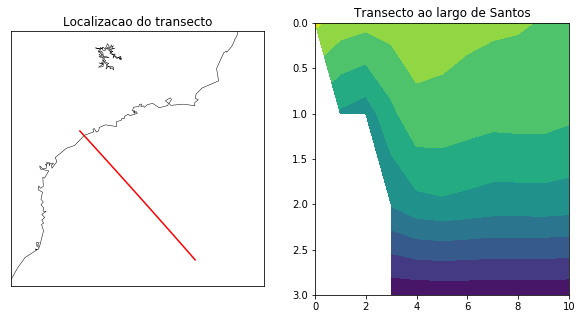

In [100]:
# visualizando a secao vertical
fig,axes = plt.subplots(ncols=2,figsize=(10,5))
ax = axes[0]
m = make_map(ax)
m.plot(nlon[jindexes,iindexes],nlat[jindexes,iindexes],'r',latlon=True)
ax.set_title('Localizacao do transecto')

ax = axes[1]
ax.contourf(transect)
ax.set_ylim([0,3])
ax.invert_yaxis()
ax.set_title('Transecto ao largo de Santos')

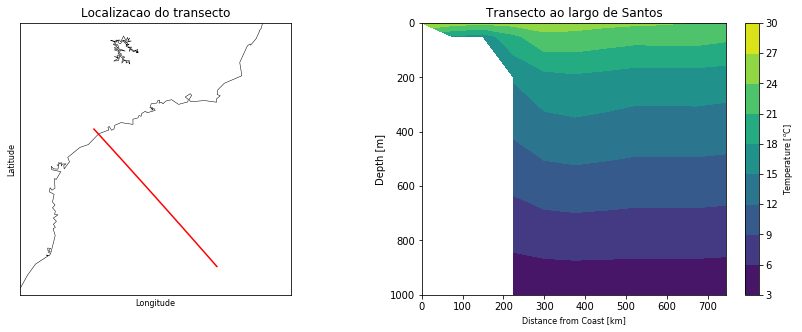

In [101]:
# visualizando a secao vertical
fig,axes = plt.subplots(ncols=2,figsize=(15,5))
ax = axes[0]
m = make_map(ax)
m.plot(nlon[jindexes,iindexes],nlat[jindexes,iindexes],'r',latlon=True)
ax.set_title('Localizacao do transecto')

ax.set_xlabel('Longitude',fontsize=8)
ax.set_ylabel('Latitude',fontsize=8)

ax = axes[1]
cf = ax.contourf(eixox,ndep.T,transect)
ax.set_ylim([0,1000])
ax.invert_yaxis()
ax.set_title('Transecto ao largo de Santos')

# enfeitando o grafico
ax.set_xlabel('Distance from Coast [km]',fontsize=8)
ax.set_ylabel('Depth [m]')

cbar = plt.colorbar(cf)
cbar.set_label('Temperature ['+ r'$^o$' +'C]',fontsize=8)